## Data preprocessing

##### Copyright (C) Microsoft Corporation.  
see license file for details

In [10]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys, os

from keras.applications.resnet50 import ResNet50
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import t_sne_bhcuda.t_sne_bhcuda.bhtsne_cuda as tsne_bhcuda

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Path variables

In [2]:
data_base_input_dir = '/datadrive/dogs_vs_cats/dogs_vs_cats_keras'
data_dir = os.path.join(data_base_input_dir, 'train')
output_dir = os.path.join(data_base_input_dir, 'processed')
os.makedirs(output_dir, mode=0o777, exist_ok=True)


In [3]:
RECOMPUTE=False
SAMPLE_DATA = False
 

In [4]:
   
# densenet layers
# name          size    connected_to
# dense_2_3_bn  1408    concatenate_311
# dense_2_8_bn  2048    concatenate_316 
# dense_2_10_bn 2304    concatenate_318  
              
# model_name_list = [ResNet50, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121]
# model_layer_list = ['','dense_2_3_bn', 'dense_2_8_bn', 'dense_2_10_bn', '']    
model_name_list = [ResNet50]
model_layer_list = ['']

sample_size = 1000
saved_data_file_appendix = ''
if SAMPLE_DATA:
    saved_data_file_appendix = '_sample'

In [5]:
training_image_files = os.listdir(data_dir)

len(training_image_files)
training_image_files[:2]
image_file_names = list(os.path.join(data_dir, fname) for fname in training_image_files)
image_file_names[:2]

20000

['dog.213.jpg', 'dog.6445.jpg']

['/datadrive/dogs_vs_cats/dogs_vs_cats_keras/train/dog.213.jpg',
 '/datadrive/dogs_vs_cats/dogs_vs_cats_keras/train/dog.6445.jpg']

#### TSNE cpp
Using the same variables as in [TSNE sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


In [6]:
perplexity = 30.0
theta = 0.5
learning_rate = 200.0
iterations = 1000
gpu_mem = 0.8
files_dir = os.path.join(data_base_input_dir, 'tsne_cpp_results')


In [7]:
def apply_tsne_to_multiple_features_cpp(output_dir, crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('tsne processing for model ' + crt_model_name.__name__)
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne_cpp.npy')
        if os.path.isfile(tsne_features_filename) and RECOMPUTE is False:
            print("tsne features found!")
        else:
            print("Computing tsne features")
            original_features = np.load(os.path.join(output_dir, 'features_' + \
                                                     crt_model_name.__name__+saved_data_file_appendix+\
                                                     crt_model_layer+'.npy'))
            print(original_features.shape)
            original_features = original_features.reshape(original_features.shape[0], -1)
            print(original_features.shape)
            images_tsne = tsne_bhcuda.t_sne(samples=original_features, use_scikit=False, files_dir=files_dir,
                        no_dims=2, perplexity=perplexity, eta=learning_rate, theta=theta,
                        iterations=iterations, gpu_mem=gpu_mem, randseed=-1, verbose=2)

            print(images_tsne.shape)
            np.save(tsne_features_filename, images_tsne)


In [9]:
%%time
apply_tsne_to_multiple_features_cpp(output_dir, model_name_list)                        

tsne processing for model ResNet50
Computing tsne features
(20000, 2048)
(20000, 2048)
/home/hoaphumanoid/notebooks/repos/transfer_learning_analysis/tsne_cpp/t_sne_bhcuda/build/linux
Read the 20000 x 2048 data matrix successfully!
Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, learning rate = 200.000000, and theta = 0.500000
Computing input similarities...

Device Name = Tesla P100-PCIE-16GB
multiProcessorCount: 56
totalGlobalMem (in MB): 16276.250000
totalGlobalMem (in GB): 15.894775
sharedMemPerBlock (in bytes): 49152
Maximum number of threads per block: 1024
Maximum size of each dimension of a block: 1024 x 1024 x 64
Maximum sizes of each dimension of a grid: 2147483647 x 65535 x 65535
Compute capability of the device = 6.0
canMapHostMemory: TRUE
deviceOverlap: TRUE
GPU memory usage: used = 738.000000 MB, free = 15538.250000 MB, total = 16276.250000 MB

GPU iteration = 0, distance elements calculated = 400000000
GPU memory usage: used = 2580.000000 M

In [11]:
labels_filename = os.path.join(output_dir, 'labels_' + \
                                              saved_data_file_appendix+\
                                              '.npy')
if os.path.isfile(labels_filename) and RECOMPUTE is False:
    print('Label file '+labels_filename+' found!')
    y = np.load(labels_filename)
else:
  y = pd.Series(training_image_files).str.contains('cat').astype(int).values
  np.save(labels_filename, y)

print(y.shape)
print(y[y==0].shape)
print(y[y==1].shape)


Label file /datadrive/dogs_vs_cats/dogs_vs_cats_keras/processed/labels_.npy found!
(20000,)
(10000,)
(10000,)


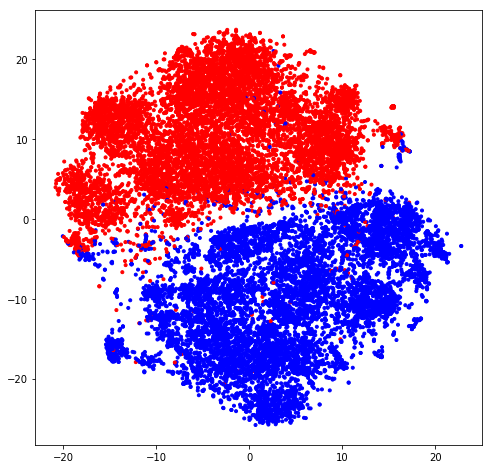

In [12]:
cat_labels = y == 0
dog_labels = y == 1
def visualize_tsne_features(crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne_cpp.npy')
        tsne_features = np.load(tsne_features_filename)
        plt.figure(figsize=(8, 8))
        plt.scatter(x = tsne_features[:,0], y=tsne_features[:,1], marker=".", c=y, cmap=plt.cm.get_cmap('bwr'))

        plt.show()
        
visualize_tsne_features(model_name_list)      